# DC Machine Electromechanical Modeling

This *Jupyter Notebook* is dedicated to the study of the **Direct Current Machine Electrical and Mechanical Modeling**. 

The following study will be developed by the implementation of *Python* code for the application and visualization of the concepts learned with the use of *NumPy* and *Plotly* libraries. 

The following model is based and adapted from [this article](https://professorcesarcosta.com.br/upload/imagens_upload/Modelagem%20de%20um%20motor%20de%20corrente%20continua.pdf).

---

## The DC Machine

The **DC Machine** is an electromechanical device that converts electrical energy into kinetic energy or vice-versa. It is one of the most used actuators in the robotics industry mostly because of its versatility, and size/power range. It has a fairly easy-to-understand mathematical model, which generally implies in an easy-to-understand control.

From now on, the machine will be referred as a motor, since it is converting electrical energy into kinetic energy.

The key idea of the electromechanical model of a motor is to understand exactly *how* the electrical energy is transformed into mechanical energy. In the case of the DC motor, it's possible to treat it as a system that receives a voltage signal to its terminals and a load torque to its rotor.

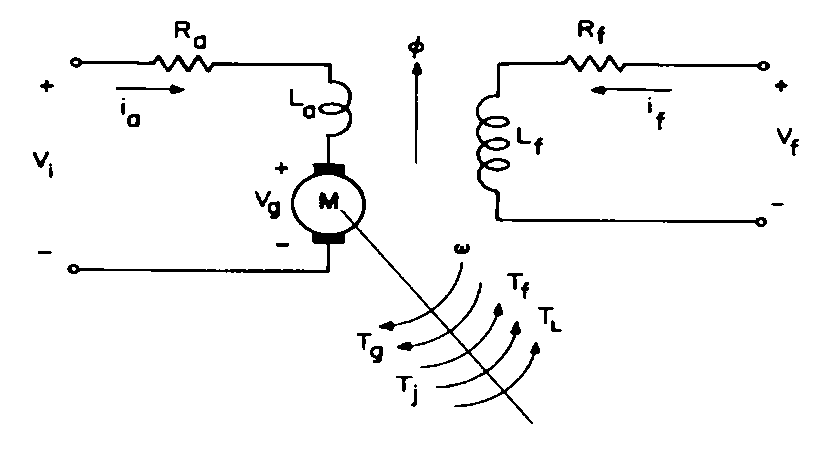

**Electrical Parameters:**
- $v_a$ is the voltage at the armature of the motor (aka, the voltage at the motor's terminals);
- $R_a$ is the armature resistance in the coil wires;
- $L_a$ is the armature inductance caused by the windings of the coils;
- $i_a$ is the current flowing through the armature circuit;
- $v_g$ is the back EMF voltage generated by the rotors rotation;
- $\Phi$ is the magnetic flux density inside the motor generated by the field circuit.

**Mechanical Parameters:**
- $\omega$ is the motors angular velocity;
- $\tau_g$ is the torque generated by the motor;
- $\tau_f$ is the torque necessary to overcome power losses such as friction and Foucault currents;
- $\tau_J$ is torque necessary to accelerate the rotating mass of the system;
- $\tau_L$ is the load torque.

The electromechanical state variables of the DC motor consists of:

$$
\begin{bmatrix} 
    v_a \\
    \tau_L
\end{bmatrix}

\xrightarrow[]{T}

\begin{bmatrix} 
    \dot{i_a} \\
    \dot{\omega}
\end{bmatrix}
$$

---

## Electrical Model of the DC Motor

The electrical modeling of the DC motor happens inside the armature circuit. Its electrical behaviour can be described by Kirchhoff's voltage law as such:

$$
v_a = R_a \cdot i_a + L_a \cdot \dot{i_a} + v_g
$$

The back EMF voltage $v_g$ can be expressed as a function of the motor's angular velocity:

$$
v_g = k \cdot \phi \cdot \omega 
$$

Where:
- $k$ is a magnetic coupling coefficient;
- $\Phi$ is the magnetic flux density inside the motor.

Assuming a permanent magnet as the flux source and disregarding effects that may modify it such as armature reaction, $k$ and $\Phi$ can be abstracted to a single constant $K_e$:

$$
v_g = K_e \cdot \omega 
$$

Then, the following expression can be achieved:

$$
v_a = R_a \cdot i_a + L_a \cdot \dot{i_a} + K_e \cdot \omega 
$$

Finishing the model as:

$$
\dot{i_a} = \frac{1}{L_a} \cdot v_a - \frac{R_a}{L_a} \cdot i_a - \frac{K_e}{L_a} \cdot \omega 
$$

For a negligible motor inductance, the voltage at the armature inductor $L_a \cdot \dot{i_a}$ can be diregarded and armature current can be directly obtained by:

$$
i_a = \frac{v_a - K_e \cdot \omega}{R_a} 
$$

$$
i_a = \frac{1}{R_a} \cdot v_a - \frac{K_e}{R_a} \cdot \omega 
$$

---

## Mechanical Model of the DC Motor

The mechanical model of the DC motor is abstracted at its rotor. By Newton's second law of motion in rotational systems, the net torque of the rotor must be null. Representing this in an equation:

$$
\tau_g = \tau_f + \tau_L + \tau_J + \tau_v
$$

$\tau_v$ is the viscous damping torque. Since it is directly proportional to the angular velocity of the rotor, this relation may be expressed in a linear equation where $b$ is the viscous damping coefficient: 

$$
\tau_v = b\cdot\omega 
$$

The inertial torque is also dependant on the angular velocity and the moment of inertia $J$ of the rotor:

$$
\tau_J = J \cdot \dot{\omega}
$$

Thus, the model can be re-written as:

$$
\tau_g = \tau_f + \tau_L + J \cdot \dot{\omega} + b\cdot\omega 
$$

For a free spinning motor with friction disregarded, the model may be simplified to:

$$
\tau_g = J \cdot \dot{\omega} + b\cdot\omega 
$$

---

## The Electromechanical Model of the DC Motor

To link both electrical and mechanical models, it's possible to make a linear relation between the generated torque and the armature current flowing on the motor:

$$
T_g = K_t \cdot i_a
$$

Where $K_t$ is the **torque constant** of the motor. By joining this equation with the mechanical model, a relation between electrical and mechanical variables is created:

$$
K_t \cdot i_a = J \cdot \dot{\omega} + b\cdot\omega 
$$

Which can be better expressed as:

$$
\dot{\omega} = \frac{K_t}{J} \cdot i_a - \frac{b}{J}\cdot\omega 
$$

For the simplified electrical model, the model expression can be obtained in terms of the armature internal parameters:

$$
K_t \cdot  \frac{v_a - K_e \cdot \omega}{R_a} = J \cdot \dot{\omega} + b\cdot\omega 
$$

Finally, the model can be expressed as the rate of change in the angular velocity of the rotor directly in function of the armature voltage:

$$
\dot{\omega} = \frac{K_t}{R_a \cdot J} \cdot v_a - \frac{K_t \cdot K_e + R_a \cdot b}{R_a \cdot J}\cdot\omega 
$$

---

In [103]:
# Importing modules...
import numpy as np

import sys
sys.path.append('..') # Go back to base directory

from modules.graph import *
from modules.viewer3d import *

In [104]:
# Direct current motor model
class DCMotor:
    def __init__(
        self,
        # Electrical parameters
        R_a, # Armature resistance
        L_a, # Armature inductance
        K_t, # Torque constant

        # Mechanical Parameters
        J, # Rotor's moment of inertia
        b, # Viscous damping coefficient

        dt=1e-4, # Differential time step

        # Initial motor status parameters (not spinning and no current flowing)
        w=0.0,  # Angular velocity
        i_a=0.0 # Armature current
    ):
        # Time parameters
        self.dt = dt

        # Electrical characteristics of the motor
        self.R_a = R_a
        self.L_a = L_a
        self.K_e = K_t
        self.K_t = K_t
 
        # Mechanical properties
        self.J = J
        self.b = b

        # Motor status
        self.i_a = i_a
        self.w = w
        
    def electromechanical_model(self, v, T):
        # Calculate and update state variables
        i_a_dot = (v - self.i_a * self.R_a - self.w * self.K_e) / self.L_a

        # Integrate using Euler's Method
        self.i_a += i_a_dot * self.dt

        # Calculate and update state variables
        w_dot = self.i_a * self.K_t / self.J - self.w * self.b / self.J - T / self.J
        
        # Integrate using Euler's Method
        self.w += w_dot * self.dt

    def get_output(self):
        return np.array(
            [
                [self.i_a], 
                [self.w]
            ]
        )

In [105]:
# Instanciating and simulating the model
DCM = DCMotor(
    # Electrical parameters
    R_a=3.0, # In ohms
    L_a=6.0e-3, # In henrys
    K_t=50.0e-3, # In N*m/A

    # Mechanical Parameters
    J=100e-6, # In Kg*m^2
    b=105e-6, # In Kg*m^2/s

    dt=1e-4, # Differential time step

    # Initial angular velocity
    w=0.0 # In rad/s
)

# Simulation time parameters
start_time = 0.0 # In Seconds
stop_time = 2.0  # In Seconds

time_vector = np.linspace(
    start_time, 
    stop_time, 
    int((stop_time - start_time) / DCM.dt)
)

# Generate PWM signal for motor's input
def pwm_signal(
    V_cc, 
    duty_cycle, 
    frequency, 
    time_vector
):
    return V_cc * (time_vector % (1 / frequency) < (1 / frequency) * duty_cycle / 100)

# Generate step input
def step_signal(
    value,
    delay
):
    return value * np.heaviside(time_vector - delay, 1)

# PWM signal parameters 
V_cc = 20 # In volts
duty_cycle = 50 # In %
frequency = 490 # In Hz

v_signal = pwm_signal(V_cc, duty_cycle, frequency, time_vector)

# Torque signal parameters
T_load = 0.05 # In N*m
T_signal = step_signal(T_load, 1) # Starts at 1 second

# Generate solution
output = []
for v, T, t in zip(v_signal, T_signal, time_vector):
    DCM.electromechanical_model(v, T)
    
    output.append(DCM.get_output())

output = np.hstack(output)

In [106]:
# Plot input variables
graph = Graph(
    title="Input in Time Domain", 
    axis_title=("Time (s)", "Armature Voltage (V)")
)

timespan = round(5/(frequency * DCM.dt)) # Numbers of samples for a timespan of 5 cycles

graph.add_trace(
    points=np.vstack((time_vector, v_signal))[:, :timespan], 
    name="v (V)"
)

graph.figure.show(renderer='notebook_connected')

In [107]:
# Plot input variables
graph = Graph(
    title="Input in Time Domain", 
    axis_title=("Time (s)", "Load Torque (N*m)")
)

graph.add_trace(
    points=np.vstack((time_vector, T_signal)), 
    name="T (N*m)"
)

graph.figure.show(renderer='notebook_connected')

In [108]:
# Plot output variables
graph = Graph(
    title="Output in Time Domain", 
    axis_title=("Time (s)", "Armature Current (A)")
)

graph.add_trace(
    points=np.vstack((time_vector, output[0])), 
    name="i_a (A)"
)

graph.figure.show(renderer='notebook_connected')

In [109]:
# Plot output variables
graph = Graph(
    title="Output in Time Domain", 
    axis_title=("Time (s)", "Rotor Angular Velocity (rad/s)")
)

graph.add_trace(
    points=np.vstack((time_vector, output[1])), 
    name="w (rad/s)"
)

graph.figure.show(renderer='notebook_connected')